<a href="https://colab.research.google.com/github/glee1228/Bag_of_words/blob/master/bag_of_words.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Recognition Using Bags of Words

### Referenced Code 

BoW :https://github.com/CyrusChiu/Image-recognition

K-Means Clustering using GPU : https://github.com/ilyaraz/pytorch_kmeans

Multi-class Linear SVM using GPU : https://github.com/murtazajafferji/svm-gpu


Porting by glee1228@naver.com

In [0]:
import pandas as pd
import pickle
import numpy as np
import random
import sklearn
from sklearn.cluster import KMeans
import scipy.cluster.vq as vq

## Google Drive Link
for Downloading pkl files

In [31]:
from google.colab import drive
import os

if os.path.exists('/content/gdrive')==False:
    drive.mount('/content/gdrive')
    print('Google Drive is mounted\n')
else:
    print('Google Drive is already mounted\n')

Google Drive is already mounted



In [32]:
os.chdir('/content/gdrive/My Drive')
print('current path ? ',os.getcwd())
print('List of files in the current path :',os.listdir(os.getcwd()))

current path ?  /content/gdrive/My Drive
List of files in the current path : ['이동훈_입과증빙서류.zip', '1018_SQL 전문가 가이드 2010 Edition.pdf', '123.mp4', '공유폴더', '교안및보고서', 'Colab Notebooks', 'foo.txt', 'workspace', 'sample_cardiac', 'retrain.py', '3DUnetCNN-master', 'segmentation', 'generic_Unet', '참가동의서.pdf', 'train.csv', 'VLAD.ipynb', 'LeNet5_Practice.ipynb', 'resized_Dataset', 'query', 'Sejongbuild_images', 'oxbuild_images', 'AILeader_Dataset', 'input', 'output', '파이썬기계학습', 'deepfashion2', '머신러닝 인터뷰 준비.gdoc', '101_ObjectCategories', 'DatasetFile.txt', 'LabelFile.txt', 'y_train.pkl', 'y_test.pkl', 'x_test.pkl', 'x_train.pkl', 'bow_codebook.pkl', 'x_train_hist.pkl', 'x_test_hist.pkl']


In [0]:
VOC_SIZE = 600

random.seed(777)

## Bag of Features Process

### 1. Prepare Dataset
Caltech101 , Cifar10 ... etc
### 2. feature extraction
SIFT descriptors ... etc
### 3. clustering and build codebook
K-means clustering algorithm .... etc
### 4. Image representation(making the histogram of features)
Vector Quantization Technique
### 5. classifier learning and recognition
SVM , Naive Bayes, ...etc


### run_all_process : True

End-To-End Learning and Recognition

In [0]:
run_all_process = False

In [0]:
prepare_dataset = False
feature_extraction = False
clustering_and_build_codebook = False
image_representation = False
learning_and_recognition = True

In [0]:
if run_all_process:
    prepare_dataset = True
    feature_extraction = True
    clustering_and_build_codebook = True
    image_representation = True
    learning_and_recognition = True

## Prepare Caltech-101 Dataset

In [0]:
def get_sample_datalist(path='./101_ObjectCategories/DatasetFile.txt', new_path="./101_ObjectCategories/SampleDatafile.txt",count=30):
    print('Getting sample data list..')
    with open(path, 'r') as f:
        paths = f.readlines()
    count_dict = {}
    new_x, new_y = [], []
    for each in paths:
        each = each.strip()
        
        label, path = each.split('$')
        if not label in count_dict.keys():
            count_dict[label] = 1
            new_x.append(path)
            new_y.append(label)
        else:
            if count_dict[label] >= count:
                pass
            else:
                count_dict[label] += 1
                new_x.append(path)
                new_y.append(label)

    result = zip(new_x, new_y)
    f = open(new_path, 'w')
    for x, y in result:
        f.write('{}${}\n'.format(y, x))
    f.close()

    return new_path,[new_x, new_y]

def load_my_data(path, test=None):
    print('load_my_data')
    with open(path, 'r') as f:
        paths = f.readlines()
    x, y = [], []
    for each in paths:
        each = each.strip()
        label, path = each.split('$')
        img = cv2.imread(path)
        if img.shape[:2] != (256,256):
            img = cv2.resize(img, (256,256))
        x.append(img)
        y.append(label)
    return [x, y]

In [0]:
import os
import glob
from sklearn.model_selection import train_test_split

if prepare_dataset:
  ! wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
  #! tar -xvzf 101_ObjectCategories.tar.gz
  #rm -rf 101_ObjectCategories.tar.gz
  dataset_path = os.path.abspath('101_ObjectCategories')
  Dataset_File = open(os.path.join(dataset_path,'DatasetFile.txt'), 'w')
  label_file = open(os.path.join(dataset_path,'LabelFile.txt'),'w')
  for class_idx, label in enumerate(os.scandir(dataset_path)):
  #   print(class_idx,label.name)
    label_file.write(str(class_idx)+'$'+label.name+'\n')
    image_paths = glob.glob(os.path.join(label.path,'*.jpg'))
    length = len(image_paths)
    for path in image_paths[:int(length)]:
      Dataset_File.write("%d$"% class_idx+path+"\n")

  Dataset_File.close()
  label_file.close()
  
  new_path,_=get_sample_datalist('./101_ObjectCategories/DatasetFile.txt','./101_ObjectCategories/SampleDatafile.txt',35) # Data Sampling
  x_train,y_train=load_my_data(new_path) # load Data
  x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size = 0.1, random_state = 77) #Split Train / Test Dataset

## Opencv Downgrade
3.4.3 version can not be used because of patents on SIFT

In [39]:
! yes | pip3 uninstall opencv-python

! yes | pip3 uninstall opencv-contrib-python

! yes | pip3 install opencv-python==3.4.2.16
 
! yes | pip3 install opencv-contrib-python==3.4.2.16

Uninstalling opencv-python-3.4.2.16:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/cv2/*
    /usr/local/lib/python3.6/dist-packages/opencv_python-3.4.2.16.dist-info/*
Proceed (y/n)?   Successfully uninstalled opencv-python-3.4.2.16
Uninstalling opencv-contrib-python-3.4.2.16:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/opencv_contrib_python-3.4.2.16.dist-info/*
Proceed (y/n)?   Successfully uninstalled opencv-contrib-python-3.4.2.16
  Using cached https://files.pythonhosted.org/packages/fa/7d/5042b668a8ed41d2a80b8c172f5efcd572e3c046c75ae029407e19b7fc68/opencv_python-3.4.2.16-cp36-cp36m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Using cached https://files.pythonhosted.org/packages/08/f1/66330f4042c4fb3b2d77a159db8e8916d9cdecc29bc8c1f56bc7f8a9bec9/opencv_contrib_python-3.4.2.16-cp36-cp36m-manylinux1_x86_64.whl


In [0]:
import cv2

In [0]:
import torch
import random
import sys

device_gpu = torch.device('cuda')
device_cpu = torch.device('cpu')

# Choosing `num_centers` random data points as the initial centers
def random_init(dataset, num_centers):
    num_points = dataset.size(0)
    dimension = dataset.size(1)
    used = torch.zeros(num_points, dtype=torch.long)
    indices = torch.zeros(num_centers, dtype=torch.long)
    for i in range(num_centers):
        while True:
            cur_id = random.randint(0, num_points - 1)
            if used[cur_id] > 0:
                continue
            used[cur_id] = 1
            indices[i] = cur_id
            break
    indices = indices.to(device_gpu)
    centers = torch.gather(dataset, 0, indices.view(-1, 1).expand(-1, dimension))
    return centers

# Compute for each data point the closest center
def compute_codes(dataset, centers):
    num_points = dataset.size(0)
    dimension = dataset.size(1)
    num_centers = centers.size(0)
    # 5e8 should vary depending on the free memory on the GPU
    # Ideally, automatically ;)
    chunk_size = int(5e8 / num_centers)
    codes = torch.zeros(num_points, dtype=torch.long, device=device_gpu)
    centers_t = torch.transpose(centers, 0, 1)
    centers_norms = torch.sum(centers ** 2, dim=1).view(1, -1)
    for i in range(0, num_points, chunk_size):
        begin = i
        end = min(begin + chunk_size, num_points)
        dataset_piece = dataset[begin:end, :]
        dataset_norms = torch.sum(dataset_piece ** 2, dim=1).view(-1, 1)
        distances = torch.mm(dataset_piece, centers_t)
        distances *= -2.0
        distances += dataset_norms
        distances += centers_norms
        _, min_ind = torch.min(distances, dim=1)
        codes[begin:end] = min_ind
    return codes

# Compute new centers as means of the data points forming the clusters
def update_centers(dataset, codes, num_centers):
    num_points = dataset.size(0)
    dimension = dataset.size(1)
    centers = torch.zeros(num_centers, dimension, dtype=torch.float, device=device_gpu)
    cnt = torch.zeros(num_centers, dtype=torch.float, device=device_gpu)
    centers.scatter_add_(0, codes.view(-1, 1).expand(-1, dimension), dataset)
    cnt.scatter_add_(0, codes, torch.ones(num_points, dtype=torch.float, device=device_gpu))
    # Avoiding division by zero
    # Not necessary if there are no duplicates among the data points
    cnt = torch.where(cnt > 0.5, cnt, torch.ones(num_centers, dtype=torch.float, device=device_gpu))
    centers /= cnt.view(-1, 1)
    return centers

def cluster(dataset, num_centers):
    centers = random_init(dataset, num_centers)
    codes = compute_codes(dataset, centers)
    num_iterations = 0
    while True:
        sys.stdout.write('.')
        sys.stdout.flush()
        num_iterations += 1
        centers = update_centers(dataset, codes, num_centers)
        new_codes = compute_codes(dataset, centers)
        # Waiting until the clustering stops updating altogether
        # This is too strict in practice
        if torch.equal(codes, new_codes):
            sys.stdout.write('\n')
            print('Converged in %d iterations' % num_iterations)
            break
        codes = new_codes
    return centers, codes


In [0]:
def extract_sift_descriptors(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return descriptors

def build_codebook(X, voc_size):
    """
    Inupt a list of feature descriptors
    voc_size is the "K" in K-means, k is also called vocabulary size
    Return the codebook/dictionary
    """
    features = np.vstack((descriptor for descriptor in X)).astype(np.float32)
    dataset = torch.from_numpy(features).to(torch.device('cuda'))
    print('Starting clustering')
    centers, codes = cluster(dataset, voc_size)
    return centers.cpu()


def input_vector_encoder(feature, codebook):
    """
    Input all the local feature of the image
    Pooling (encoding) by codebook and return
    """
    code, _ = vq.vq(feature, codebook)
    word_hist, bin_edges = np.histogram(code, bins=range(codebook.shape[0] + 1), normed=True)
    return word_hist

def bootstrap_x_y_resample(x,y, n=None):
    if n == None:
        n = len(x)
    if len(x)!=len(y):
        print('the number of data is not match the number of label')
    resample_i = np.floor(np.random.rand(n) * len(x)).astype(int)
    X_resample = np.array(x)[resample_i]
    Y_resample = np.array(y)[resample_i]
    # print('original label mean:', sum(np.array(y).astype(int)) / len(y))
    # print('resampled label mean:', sum(np.array(Y_resample).astype(int)) / len(Y_resample))
    return X_resample,Y_resample

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn import svm

In [0]:
def svm_classifier(x_train, y_train, x_test=None, y_test=None):
    if x_test is None and y_test is None:
        x_train, x_test, y_train, y_test = train_test_split(
                x_train, y_train, test_size=0.2, random_state=6)
        print("Spliting train:{}/test:{} from training data".format(len(x_train), len(x_test)))

    #### Time to spend too much
    C_range = 10.0 ** np.arange(-2, 4)
#     gamma_range = 10.0 ** np.arange(-4, 4)
#     param_grid = dict(gamma=gamma_range.tolist(), C=C_range.tolist())

    # Grid search for C, gamma, 5-fold CV
    param_grid = dict(C=C_range.tolist())
    print("Tuning hyper-parameters\n")
#     clf = GridSearchCV(svm.SVC(), param_grid, cv=5, n_jobs=-1)
    clf = GridSearchCV(svm.LinearSVC(), param_grid, cv=3, n_jobs=-1)
   
    clf.fit(x_train, y_train)
    # print("Best parameters set found on development set:\n")
    # print(clf.best_estimator_)
    print("\nGrid scores on development set:\n")
    test_score = clf.cv_results_['mean_test_score']
    test_std = clf.cv_results_['std_test_score']
    params = clf.cv_results_['params']
    for i in range(len(test_score)):
        print("%0.3f (+/-%0.03f) for %r" % (test_score[i], test_std[i] * 2, params[i]))
    print("\nDetailed classification report:\n")
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.\n")
    y_true, y_pred = y_test, clf.predict(x_test)
    #print(classification_report(y_true, y_pred, target_names=get_label()))
    print(classification_report(y_true, y_pred))


In [62]:
# Feature(SIFT Descriptors) Extraction

if feature_extraction:
    # Training
    print("SIFT feature extraction")
    x_train = [extract_sift_descriptors(img) for img in x_train]
    x_test = [extract_sift_descriptors(img) for img in x_test]
    # Remove None in SIFT extraction
    x_train = [each for each in zip(x_train, y_train) if not each[0] is None]
    x_train, y_train = zip(*x_train)
    x_test = [each for each in zip(x_test, y_test) if not each[0] is None]
    x_test, y_test = zip(*x_test)
    print("Train/Test split: {:d}/{:d}".format(len(y_train), len(y_test)))
    with open('./x_train.pkl','wb') as f:
        pickle.dump(x_train, f)
    with open('./x_test.pkl','wb') as f:
        pickle.dump(x_test, f)
    with open('./y_train.pkl', 'wb') as f:
        pickle.dump(y_train, f)
    with open('./y_test.pkl', 'wb') as f:
        pickle.dump(y_test, f)
else:
    with open('./x_train.pkl','rb') as fp:
        x_train = pickle.load(fp)
    with open('./x_test.pkl','rb') as fp:
        x_test = pickle.load(fp)
    with open('./y_train.pkl','rb') as fp:
        y_train = pickle.load(fp)
    with open('./y_test.pkl','rb') as fp:
        y_test = pickle.load(fp)
    print("SIFT features ard loaded")

SIFT features ard loaded


In [0]:
# class_value, class_count = np.unique(y_train, return_counts=True)
# print('label value :',class_value)
# print('count per label :', class_count)
# print('Bootstrap n={} resampling'.format(n))
# x_train, y_train = bootstrap_x_y_resample(x_train, y_train, n=n)

In [67]:
# Builing Codebook and Clustering
codebook =None
if clustering_and_build_codebook:
    print("Building the codebook, Wait a minute")
    codebook = build_codebook(x_train, voc_size=VOC_SIZE)
    print('codebook shape : ',codebook.shape)
    with open('./bow_codebook.pkl', 'wb') as f:
        pickle.dump(codebook, f)
else :
    print('Loading the last codebook.')
    with open('./bow_codebook.pkl','rb') as fp:
        codebook = pickle.load(fp)

Loading the last codebook.


In [68]:
# Histogram of the frequency of code words by VQ
if image_representation:
    print('Approximate data as codeword vectors by Vector Quantization and Making the histogram of data ')
    print("Bag of words encoding")
    x_train = [input_vector_encoder(x, codebook) for x in x_train]
    x_train = np.asarray(x_train)
    x_test = [input_vector_encoder(each, codebook) for each in x_test]
    x_test = np.asarray(x_test)
    with open('./x_train_hist.pkl','wb') as f:
        pickle.dump(x_train, f)
    with open('./x_test_hist.pkl','wb') as f:
        pickle.dump(x_test, f)
else :
    print('Loading the last Image representation')
    with open('./x_train_hist.pkl','rb') as fp:
        x_train = pickle.load(fp)
    with open('./x_test_hist.pkl','rb') as fp:
        x_test = pickle.load(fp)

Loading the last Image representation


In [69]:
x_train.shape

(3200, 600)

In [0]:
y_train= np.array([int(y)for y in y_train])
y_test = np.array([int(y)for y in y_test])

In [0]:
import cupy as xp 

# Move data to GPU
x_train = xp.asarray(x_train)
x_test =  xp.asarray(x_test)
y_train = xp.asarray(y_train)
y_test = xp.asarray(y_test)

In [52]:
# To use cupy
! curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   6781      0 --:--:-- --:--:-- --:--:--  6752
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.
+ pip install -q cupy-cuda100  chainer 
+ set +ex
Installation succeeded!


In [0]:
# SVM-Gpu
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import preprocessing
import time
import pdb
def timeit(f):

    def timed(*args, **kw):

        ts = time.time()
        result = f(*args, **kw)
        te = time.time()
        
        print('func:%r args:%r took: %2.4f sec' % (f.__name__, kw, te-ts))
        return result

    return timed

@timeit
def train_and_compute_misclassification(kernel, kernel_params, classification_strategy, x_train, y_train, x_test, y_test, lambduh=1, use_optimal_lambda=False, n_folds=3, max_iter=200):   
    print('svm-gpu, {} kernel, parameters {}'.format(kernel, kernel_params))
    
    svm = SVM(kernel, kernel_params, lambduh, max_iter, classification_strategy, x=x_train, y=y_train, n_folds=n_folds, display_plots=True)
    
    svm.fit(x_train, y_train, use_optimal_lambda=use_optimal_lambda)

    misclassification_error = svm.compute_misclassification_error(x_test, y_test)
    print('Misclassification error (test), {}, {}lambda = {} : {}\n'.format(svm._classification_strategy, ('optimal ' if use_optimal_lambda else ''), svm._lambduh, misclassification_error))


In [0]:
# SVM-Gpu
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np 
import scipy.linalg 
import pandas as pd 
import matplotlib.pyplot as plt
import itertools
import pdb
xp.random.seed(0)
def kernel_linear(x1, x2, params):
    return x1.dot(x2.T)

def kernel_poly(x1, x2, params):
    return (x1.dot(x2.T) + 1)**params['degree']

def kernel_rbf(x1, x2, params):
    if x2.ndim == 2:
        return xp.exp(-xp.linalg.norm(xp.subtract(x1[:, :, xp.newaxis], x2[:, :, xp.newaxis].T), axis=1)**2/params['sigma']**2)
    else:
        return xp.exp(-xp.linalg.norm(xp.subtract(x1, x2), axis=1) ** 2 / params['sigma'] ** 2)

def kernel_rbf_sklearn(x1, x2, params):
    return xp.asarray(rbf_kernel(xp.asnumpy(x1), gamma=params['sigma']))

def kernel_sigmoid(x1, x2, params):
    return xp.tanh(params['alpha'] * (x1.dot(x2.T)) + params['beta'])
    
kernel_dict = {'linear': kernel_linear,
               'poly': kernel_poly,
               'rbf': kernel_rbf,
               'rbf_sklearn': kernel_rbf_sklearn,
               'sigmoid': kernel_sigmoid
                }


class SVM():
    """support vector machine"""

    def __init__(self, kernel, kernel_params, lambduh=1, max_iter=1000, classification_strategy='ovr', x=None, y=None, n_folds=3, lambda_vals=None, use_optimal_lambda=False, display_plots=False, logging=False):
        """initialize the classifier"""

        self._kernel = kernel
        self._kernel_params = kernel_params
        self._lambduh = lambduh
        self._max_iter = max_iter
        self._classification_strategy = classification_strategy
        self._y = y
        self._set_x(x)

        self._coef_matrix = []

        self._n_folds = n_folds
        self._display_plots = display_plots
        self._logging = logging
        self._lambda_vals = lambda_vals
        if self._lambda_vals is None:
            self._lambda_vals = [10**i for i in range(-3, 4)]
        self._use_optimal_lambda = use_optimal_lambda

    def fit(self, x=None, y=None, prevent_relabel=False, use_optimal_lambda=False):
        """Trains the kernel support vector machine with the huberized hinge loss"""
        self._set_x(x)
        if y is not None:
            self._y = y
        self._K = self._compute_gram_matrix()
        self._n = len(self._x)
        objective_val_size = int(self._max_iter//10) + (1 if self._max_iter % 10 == 0 else 0)
        self._objective_val_per_iter = xp.zeros(objective_val_size)
        
        if self._classification_strategy == 'ovr':
            iterate_over = xp.asarray(xp.unique(xp.asnumpy(self._y)))
            
        elif self._classification_strategy == 'ovo' or self._classification_strategy == 'binary':
            iterate_over = SVM._get_unique_pairs(self._y)

        if self._use_optimal_lambda or use_optimal_lambda:
            self._lambduh, misclassification_error = self.compute_optimal_lambda()
            print('Misclassification error (train), {}, optimal lambda = {} : {}'.format(self._classification_strategy, self._lambduh, misclassification_error))

        for i in range(len(iterate_over)):
            if self._logging:
                print('Training classifier {} of {}'.format(i + 1, len(iterate_over)))
            
            if self._classification_strategy == 'ovr':
                primary_class = iterate_over[i]
                x_filtered, y_filtered = SVM._filter_data_by_class_ovr(self._x, self._y, primary_class)
            elif self._classification_strategy == 'ovo':
                pair = iterate_over[i]
                x_filtered, y_filtered = SVM.filter_data_by_class_ovo(self._x, self._y, pair, prevent_relabel)
            elif self._classification_strategy == 'binary':
                pair = iterate_over[i]
                self._n = len(self._x)
                self._K = self._compute_gram_matrix()
                if prevent_relabel:
                    self._primary_class = 1
                    self._secondary_class = -1
                else:
                    self._primary_class = pair[0]
                    self._secondary_class = pair[1]
                    self._y = xp.where(self._y == self._primary_class, 1, -1)
                self._coef_matrix, self._objective_val_per_iter, self._misclassification_error_per_iter = self._fast_gradient_descent()
                return

            svm = SVM(self._kernel, self._kernel_params, self._lambduh, self._max_iter, 'binary', display_plots= True)
            
            svm.fit(x_filtered, y_filtered, prevent_relabel=True)
            
            self._coef_matrix.append(svm._coef_matrix)
            self._objective_val_per_iter += svm._objective_val_per_iter * (1/len(iterate_over))
        if self._display_plots:
            self.objective_plot()
        return

    def cross_validation_error(self):
        error_per_lambda = xp.zeros(len(self._lambda_vals))

        for i in range(len(self._lambda_vals)):
            lambduh = self._lambda_vals[i]
            if self._logging:
                print('lambduh = {} ({} of {})'.format(lambduh, i + 1, num_lambda))
            error_per_fold = xp.zeros(self._n_folds)
            for j in range(self._n_folds):
                fold_size = int(self._n/self._n_folds)
                indicies = xp.array(range(0, self._n))
                fold_indicies = ((indicies >= fold_size*j) & (indicies <= fold_size*(j+1)))
                x_train = self._x[fold_indicies == True]
                y_train = self._y[fold_indicies == True]       
                x_test = self._x[fold_indicies == False]
                y_test = self._y[fold_indicies == False]
                y_train = y_train.reshape((len(y_train), 1))
                y_test = y_test.reshape((len(y_test), 1))

                y_train = xp.ravel(y_train)
                y_test = xp.ravel(y_test)
                
                svm = SVM(self._kernel, self._kernel_params, lambduh, self._max_iter, self._classification_strategy)
                svm.fit(x_train, y_train)   
                error_per_fold[j] = svm.compute_misclassification_error(x_test, y_test)

            error_per_lambda[i] = xp.mean(error_per_fold)
            
        return error_per_lambda.tolist()

    def compute_optimal_lambda(self):
        cross_validation_error = self.cross_validation_error()
        if self._display_plots:
            df = pd.DataFrame({'lambda':self._lambda_vals, 'Cross validation error':xp.asnumpy(cross_validation_error)})
            display(df)
            df.plot('lambda', 'Cross validation error', logx=True)
            plt.show()
        return self._lambda_vals[np.nanargmin(cross_validation_error)], np.min(cross_validation_error)

    def compute_misclassification_error(self, x, y): 
        y_pred = self.predict(x)
        return xp.mean(y_pred != y)

    def predict(self, x):
        x = self._standardize(x)
        if self._classification_strategy == 'ovr':
            return self._predict_ovr(x)
        elif self._classification_strategy == 'ovo':
            return self._predict_ovo(x)
        else:
            return self._predict_binary(x)

    def objective_plot(self):
        fig, ax = plt.subplots()
        ax.plot(np.array(range(len(self._objective_val_per_iter)))*10, xp.asnumpy(self._objective_val_per_iter), label='Train', c='red')
        plt.xlabel('Iteration')
        plt.ylabel('Objective value')
        plt.title('Objective value vs. iteration when lambda=' + str(self._lambduh))
        ax.legend(loc='upper right') 
        plt.show()

    def plot_misclassification_error(self): 
        if self._classification_strategy == 'binary':
            fig, ax = plt.subplots() 
            ax.plot(np.array(range(len(self._misclassification_error_per_iter)))*10, xp.asnumpy(self._misclassification_error_per_iter), label='Train', c='red') 
            plt.xlabel('Iteration') 
            plt.ylabel('Misclassification error') 
            plt.title('Misclassification error vs iteration') 
            ax.legend(loc='upper right') 
            plt.show()
        else:
            print('Plotting misclassification error only available for binary classification.')

    def _set_x(self, x):
        if x is not None:
            self._n = len(x)
            self._x_sd = xp.std(x, axis=0)
            self._x_mean = xp.mean(x, axis=0)
            self._x = self._standardize(x)

    def _standardize(self, x):
        sd = self._x_sd
        mean = self._x_mean
        mean[sd == 0] = 0
        sd[sd == 0] = 1
        return (x - mean) / sd

    @staticmethod
    def filter_data_by_class_ovo(x, y, classes, prevent_relabel=False):
        x = SVM._select_classes(x, y, classes)
        y = SVM._select_classes(y, y, classes)
        if prevent_relabel == False:
            y = xp.where(y == classes[0], 1, -1)
                    
        return x, y

    @staticmethod
    def subset_data(x, y, max_samples):
        if max_samples is None or max_samples > len(x):
            return x, y
        else:
            idx = np.random.choice(np.arange(len(x)), max_samples, replace=False)
            return x[idx], y[idx]
    @staticmethod   
    def subset_data_gpu(x, y, max_samples):
        x, y = subset_data(x, y, max_samples)
        return xp.asarray(x), xp.asarray(y)

    @staticmethod
    def _get_unique_pairs(y):
        return pd.Series(list(itertools.combinations(np.unique(xp.asnumpy(y)),2)))

    @staticmethod
    def _select_classes(x, y, classes):
        if len(classes) == 2:
            return x[(y == classes[0]) | (y == classes[1])]
        else:
            return x[xp.asarray(np.isin(xp.asnumpy(y), classes))]

    @staticmethod
    def _select_classes_ovr(x, y, primary_class):
        positive = x[y == primary_class]
        negative = x[y != primary_class]
        # Get random rows of the same length as the positive matrix
        if len(positive) < len(negative):  
            negative = negative[xp.random.choice(negative.shape[0], len(positive), replace=False)]
        return xp.concatenate((positive, negative), axis=0)

    @staticmethod
    def _filter_data_by_class_ovr(x, y, primary_class):
        x = SVM._select_classes_ovr(x, y, primary_class)
        y = SVM._select_classes_ovr(y, y, primary_class)
        y = xp.where(y == primary_class, 1, -1)
        
        return x, y

    def _compute_gradient(self, alpha):
        """Computes the gradient ∇F(β) of F"""
        K_alpha = xp.dot(self._K, alpha)
        grad = -2 / self._n * xp.sum(self._y[:, xp.newaxis] * self._K * xp.max(xp.stack((xp.zeros_like(self._y), 1 - self._y * K_alpha)), axis=0)[:, xp.newaxis], axis=0) + 2 * self._lambduh * K_alpha    
        return grad

    def _objective(self, alpha):
        K_alpha = xp.dot(self._K, alpha)
        return 1 / self._n * xp.sum(xp.max(xp.stack((xp.zeros_like(self._y), 1 - self._y * K_alpha)), axis=0) ** 2) + self._lambduh * alpha.dot(K_alpha)

    def _backtracking_line_search(self, alpha, eta=1, alphaparam=0.5, betaparam=0.8, max_iter=100): 
        grad_alpha = self._compute_gradient(alpha) 
        norm_grad_alpha = xp.linalg.norm(grad_alpha) 
        found_eta = 0 
        iter = 0 
        while found_eta == 0 and iter < max_iter: 
            if self._objective(alpha - eta * grad_alpha) < self._objective(alpha) - alphaparam * eta * norm_grad_alpha ** 2: 
                found_eta = 1 
            elif iter == max_iter: 
                raise ('Max number of iterations of backtracking line search reached') 
            else: 
                eta *= betaparam 
                iter += 1 
            return eta

    def _compute_gram_matrix(self):
        """Computes, for any set of datapoints x1,...,xn, the kernel matrix K"""
        kernel = self._kernel
        if kernel == 'rbf':
            kernel += '_sklearn'
        gram = kernel_dict[kernel](self._x, self._x, self._kernel_params)
        return gram

    # 
    def _kernel_eval(self, x, x_train):
        keval = kernel_dict[self._kernel](x_train, x, self._kernel_params)
        return keval

    def _fast_gradient_descent(self):
        eta_init = self._optimal_eta_init()

        alpha = xp.zeros(self._n)
        theta = xp.zeros(self._n)
        eta = eta_init
        grad_theta = self._compute_gradient(theta)
        objective_val_size = int(self._max_iter//10) + (1 if self._max_iter % 10 == 0 else 0)
        objective_vals = xp.ones(objective_val_size)
        misclassification_error_per_iter = xp.ones(objective_val_size)
        iter = 0
        while iter < self._max_iter:
            eta = self._backtracking_line_search(theta, eta=eta)
            alpha_new = theta - eta * grad_theta
            theta = alpha_new + iter / (iter + 3) * (alpha_new - alpha)
            grad_theta = self._compute_gradient(theta)
            alpha = alpha_new
            iter += 1
            if self._display_plots and iter % 10 == 0:
                objective_vals[int(iter/10)] = self._objective(alpha)
                self._coef_matrix = alpha
                misclassification_error_per_iter[int(iter/10)] = self.compute_misclassification_error(self._x, xp.where(self._y > 0, self._primary_class, self._secondary_class))
            
        return alpha, objective_vals, misclassification_error_per_iter

    def _predict_binary(self, x):      
        return self._prediction_binary(self._coef_matrix, x, self._x, self._primary_class, self._secondary_class)

    def _predict_ovo(self, x):        
        def mode(a):
            counts = xp.bincount(a.astype(xp.int64))
            return xp.argmax(counts)
        pairs = SVM._get_unique_pairs(self._y)
        predictions = xp.zeros((x.shape[0], len(pairs)))
        for i in range(len(pairs)):
            pair = pairs[i]
            alpha = self._coef_matrix[i]
            x_train_filtered, y_train_filtered = SVM.filter_data_by_class_ovo(self._x, self._y, pair)
            y_pred = self._prediction_binary(alpha, x, x_train_filtered, pair[0], pair[1])
            predictions[:,i] = y_pred
        return xp.stack([mode(p) for p in predictions])

    def _predict_ovr(self, x):
        y_unique = xp.asarray(xp.unique(xp.asnumpy(self._y)))
        prediction_probabilities = xp.zeros((x.shape[0], len(y_unique)))
        for i in range(len(y_unique)):
            alpha = self._coef_matrix[i]
            x_train_filtered, y_train_filtered = SVM._filter_data_by_class_ovr(self._x, self._y, y_unique[i])
            pred_prob = self._prediction_prob(alpha, x, x_train_filtered)
            prediction_probabilities[:,i] = pred_prob 

        return xp.stack([y_unique[xp.argmax(p)] for p in prediction_probabilities])

    def _prediction_prob(self, alpha, x, x_train):
        return xp.dot(self._kernel_eval(x, x_train).T, alpha)

    def _prediction_binary(self, alpha, x, x_train, class1=1, class2=-1):
        pred_prob = self._prediction_prob(alpha, x, x_train)
        return xp.where(pred_prob > 0, class1, class2)
    
    def _optimal_eta_init(self):
        return 1 / scipy.linalg.eigh(xp.asnumpy(2 / self._n * xp.dot(self._K, self._K) + 2 * self._lambduh * self._K), eigvals=(self._n - 1, self._n - 1), eigvals_only=True)[0]

svm-gpu, linear kernel, parameters {}


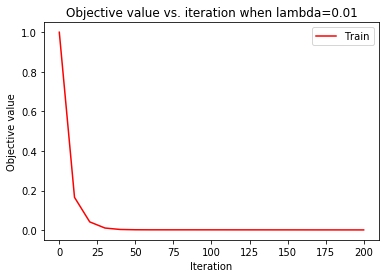

Misclassification error (test), ovr, lambda = 0.01 : 0.8651685393258427

func:'train_and_compute_misclassification' args:{'lambduh': 0.01, 'use_optimal_lambda': False} took: 49.7543 sec
svm-gpu, linear kernel, parameters {}


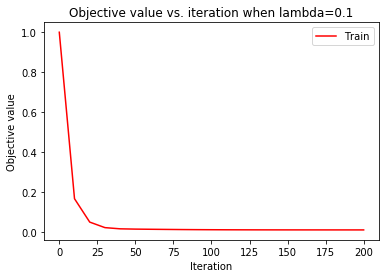

Misclassification error (test), ovr, lambda = 0.1 : 0.9213483146067416

func:'train_and_compute_misclassification' args:{'lambduh': 0.1, 'use_optimal_lambda': False} took: 50.7575 sec
svm-gpu, linear kernel, parameters {}


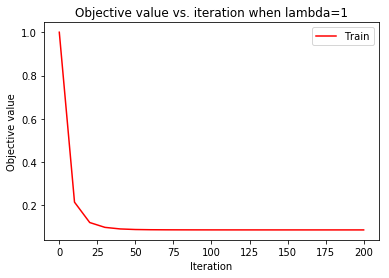

Misclassification error (test), ovr, lambda = 1 : 0.8960674157303371

func:'train_and_compute_misclassification' args:{'lambduh': 1, 'use_optimal_lambda': False} took: 50.9285 sec
svm-gpu, linear kernel, parameters {}


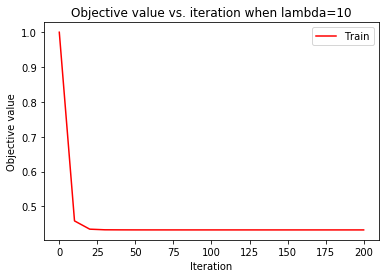

Misclassification error (test), ovr, lambda = 10 : 0.851123595505618

func:'train_and_compute_misclassification' args:{'lambduh': 10, 'use_optimal_lambda': False} took: 50.7687 sec
svm-gpu, linear kernel, parameters {}


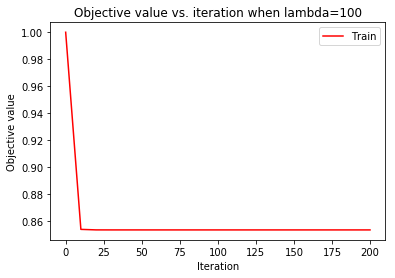

Misclassification error (test), ovr, lambda = 100 : 0.8202247191011236

func:'train_and_compute_misclassification' args:{'lambduh': 100, 'use_optimal_lambda': False} took: 50.8406 sec
svm-gpu, linear kernel, parameters {}


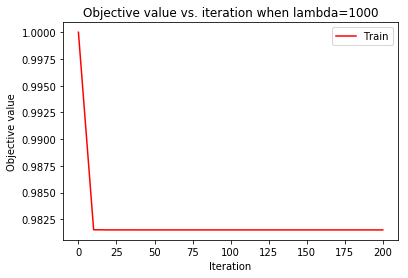

Misclassification error (test), ovr, lambda = 1000 : 0.8342696629213483

func:'train_and_compute_misclassification' args:{'lambduh': 1000, 'use_optimal_lambda': False} took: 50.9883 sec
svm-gpu, linear kernel, parameters {}


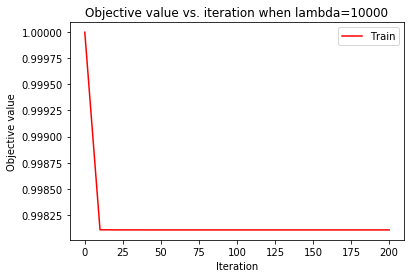

Misclassification error (test), ovr, lambda = 10000 : 0.8455056179775281

func:'train_and_compute_misclassification' args:{'lambduh': 10000, 'use_optimal_lambda': False} took: 50.4573 sec


In [55]:
train_and_compute_misclassification('linear',{}, 'ovr', x_train, y_train, x_test, y_test,lambduh=0.01, use_optimal_lambda=False)
train_and_compute_misclassification('linear',{}, 'ovr', x_train, y_train, x_test, y_test,lambduh=0.1, use_optimal_lambda=False)
train_and_compute_misclassification('linear',{}, 'ovr', x_train, y_train, x_test, y_test,lambduh=1, use_optimal_lambda=False)
train_and_compute_misclassification('linear',{}, 'ovr', x_train, y_train, x_test, y_test,lambduh=10, use_optimal_lambda=False)
train_and_compute_misclassification('linear',{}, 'ovr', x_train, y_train, x_test, y_test,lambduh=100, use_optimal_lambda=False)
train_and_compute_misclassification('linear',{}, 'ovr', x_train, y_train, x_test, y_test,lambduh=1000, use_optimal_lambda=False)
train_and_compute_misclassification('linear',{}, 'ovr', x_train, y_train, x_test, y_test,lambduh=10000, use_optimal_lambda=False)

In [72]:
if learning_and_recognition:
    svm_classifier(x_train, y_train, x_test,y_test)
    
    
    

Tuning hyper-parameters


Grid scores on development set:

0.058 (+/-0.033) for {'C': 0.01}
0.138 (+/-0.007) for {'C': 0.1}
0.198 (+/-0.016) for {'C': 1.0}
0.268 (+/-0.012) for {'C': 10.0}
0.274 (+/-0.004) for {'C': 100.0}
0.228 (+/-0.023) for {'C': 1000.0}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      1.00      0.67         1
          10       0.00      0.00      0.00         4
         100       0.25      0.50      0.33         2
         101       0.25      0.25      0.25         4
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         2
          14       0.33      0.50      0.40         2
          15       0.50      0.17      0.25         6
          